Loading dataset: iot23_500.csv
Dataset loaded successfully.
Data shape: (500, 21)
Dropped identifier columns: ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p']
Encoded target labels: 5 classes identified.
Data split into training and testing sets (non-stratified).
Random Forest model training completed.

Model Evaluation:
Accuracy: 0.6267
Macro Precision: 0.6522
Macro Recall: 0.5192
Macro F1-Score: 0.5336

Classification Report:
                           precision    recall  f1-score   support

                   Benign       1.00      0.37      0.54        19
                     DDoS       1.00      0.82      0.90        17
                    Okiru       0.41      0.85      0.55        33
PartOfAHorizontalPortScan       0.85      0.56      0.67        81

                micro avg       0.66      0.63      0.64       150
                macro avg       0.82      0.65      0.67       150
             weighted avg       0.79      0.63      0.66       150



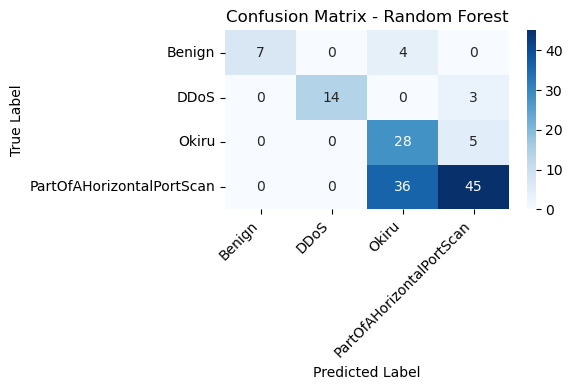


Top 15 Most Important Features:
                     Feature  Importance
5    num_proc__orig_ip_bytes    0.446557
4        num_proc__orig_pkts    0.161641
0         num_proc__duration    0.137584
11  cat_proc__conn_state_OTH    0.101226
18       cat_proc__history_S    0.057954
16       cat_proc__history_C    0.051097
12   cat_proc__conn_state_S0    0.031059
2       num_proc__resp_bytes    0.003350
17      cat_proc__history_Dd    0.002522
9        cat_proc__proto_udp    0.002515
1       num_proc__orig_bytes    0.001694
7    num_proc__resp_ip_bytes    0.001049
13   cat_proc__conn_state_SF    0.000868
6        num_proc__resp_pkts    0.000479
8        cat_proc__proto_tcp    0.000402


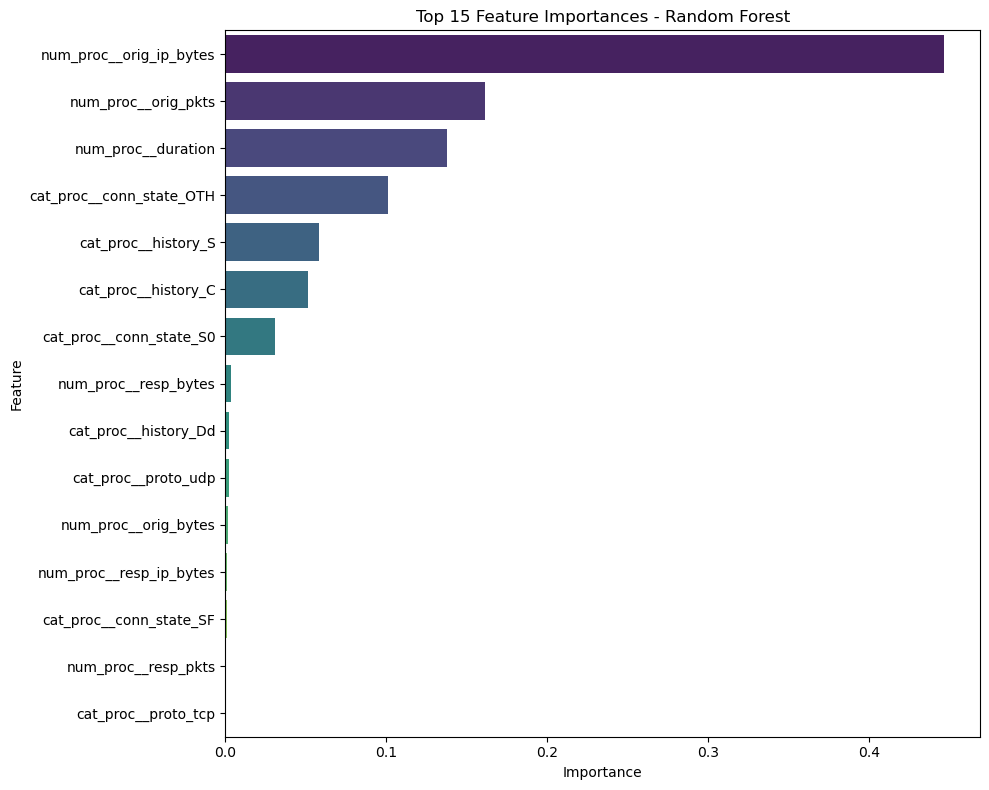


Fingerprint Table (Average Class Probabilities):
                             Benign       C&C      DDoS     Okiru  \
True_Label                                                          
Benign                     0.569776  0.225225  0.002105  0.121225   
DDoS                       0.000000  0.000000  0.844370  0.034004   
Okiru                      0.093130  0.000000  0.026841  0.524664   
PartOfAHorizontalPortScan  0.051134  0.000603  0.040301  0.317608   

                           PartOfAHorizontalPortScan  
True_Label                                            
Benign                                      0.081668  
DDoS                                        0.121625  
Okiru                                       0.355366  
PartOfAHorizontalPortScan                   0.590354  
Fingerprint table saved to 'rf_fingerprints.csv'


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Load dataset
data_file = 'iot23_500.csv'
fingerprint_output_file = 'rf_fingerprints.csv'

print(f"Loading dataset: {data_file}")
try:
    traffic_data = pd.read_csv(data_file)
    if 'Unnamed: 0' in traffic_data.columns:
        traffic_data = traffic_data.drop(columns=['Unnamed: 0'])
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: File not found: {data_file}.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

print(f"Data shape: {traffic_data.shape}")

# Drop identifier columns
identifier_columns = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p']
existing_ids_to_drop = [col for col in identifier_columns if col in traffic_data.columns]
working_data = traffic_data.drop(columns=existing_ids_to_drop)
print(f"Dropped identifier columns: {existing_ids_to_drop}")

# Process numeric features
numeric_features = [
    'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'
]
numeric_features = [col for col in numeric_features if col in working_data.columns]

for col in numeric_features:
    if working_data[col].dtype == 'object':
        working_data[col] = working_data[col].replace('-', 0)
        working_data[col] = pd.to_numeric(working_data[col], errors='coerce').fillna(0)
    if not pd.api.types.is_numeric_dtype(working_data[col]):
        working_data[col] = working_data[col].astype(float)

# Process categorical/text features
text_features = ['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'history']
text_features = [col for col in text_features if col in working_data.columns]

for col in text_features:
    working_data[col] = working_data[col].fillna('-').astype(str)

# Drop 'history' if too many unique values
if 'history' in text_features and working_data['history'].nunique() > 50:
    text_features.remove('history')
    working_data = working_data.drop(columns=['history'])

# Separate features and target
features = working_data.drop(columns=['label'])
target_labels_text = working_data['label']

# Encode target labels
label_converter = LabelEncoder()
labels_numeric = label_converter.fit_transform(target_labels_text)
class_names = label_converter.classes_
print(f"Encoded target labels: {len(class_names)} classes identified.")

# Define preprocessing for numeric and categorical features
numeric_processor = Pipeline(steps=[('scaler', StandardScaler())])
text_processor = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
feature_processor = ColumnTransformer(
    transformers=[
        ('num_proc', numeric_processor, numeric_features),
        ('cat_proc', text_processor, text_features)],
    remainder='passthrough'
)

# Split dataset into training and testing sets
try:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels_numeric, test_size=0.3, random_state=42, stratify=labels_numeric)
    print("Data split into training and testing sets (stratified).")
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels_numeric, test_size=0.3, random_state=42)
    print("Data split into training and testing sets (non-stratified).")

# Define and train the Random Forest pipeline
model_pipeline = Pipeline(steps=[
    ('preprocess_features', feature_processor),
    ('classifier', RandomForestClassifier(
        n_estimators=50, random_state=42, class_weight='balanced',
        n_jobs=-1, max_depth=10, min_samples_split=5))
])
model_pipeline.fit(X_train, y_train)
print("Random Forest model training completed.")

# Evaluate model performance
predictions = model_pipeline.predict(X_test)
probabilities = model_pipeline.predict_proba(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro', zero_division=0)
recall = recall_score(y_test, predictions, average='macro', zero_division=0)
f1 = f1_score(y_test, predictions, average='macro', zero_division=0)

print(f"\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")

# Print detailed classification report
present_labels_in_test = sorted(np.unique(y_test))
report_target_names = [class_names[i] for i in present_labels_in_test]
report = classification_report(y_test, predictions, labels=present_labels_in_test,
                               target_names=report_target_names, zero_division=0)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions, labels=present_labels_in_test)
plt.figure(figsize=(max(6, len(report_target_names)*0.6), max(4, len(report_target_names)*0.5)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=report_target_names, yticklabels=report_target_names)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature importance analysis
try:
    feature_processor_step = model_pipeline.named_steps['preprocess_features']
    classifier = model_pipeline.named_steps['classifier']

    try:
        processed_feature_names = feature_processor_step.get_feature_names_out()
    except AttributeError:
        # Fallback for older versions of scikit-learn
        ohe_transformer = feature_processor_step.named_transformers_['cat_proc'].named_steps['onehot']
        ohe_categories = ohe_transformer.categories_
        cat_feature_names_out = []
        for i, col in enumerate(text_features):
            for category in ohe_categories[i]:
                cat_feature_names_out.append(f"{col}_{category}")
        processed_feature_names = numeric_features + cat_feature_names_out

    importances = classifier.feature_importances_
    if len(processed_feature_names) == len(importances):
        importance_df = pd.DataFrame({'Feature': processed_feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print("\nTop 15 Most Important Features:")
        print(importance_df.head(15))

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
        plt.title('Top 15 Feature Importances - Random Forest')
        plt.tight_layout()
        plt.show()
    else:
        print("Feature names and importance values do not match in length.")
except Exception as e:
    print(f"Error computing feature importances: {e}")

# Generate fingerprint table (average predicted probabilities per class)
try:
    proba_df = pd.DataFrame(probabilities, columns=class_names)
    true_labels_text_test = label_converter.inverse_transform(y_test)
    proba_df['True_Label'] = true_labels_text_test

    fingerprint_table = proba_df.groupby('True_Label').mean()

    print("\nFingerprint Table (Average Class Probabilities):")
    print(fingerprint_table)

    fingerprint_table.to_csv(fingerprint_output_file)
    print(f"Fingerprint table saved to '{fingerprint_output_file}'")

except Exception as e:
    print(f"Error generating fingerprint table: {e}")
